In [ ]:
# default_exp funcs.train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian
import wandb
from madgrad import MADGRAD
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def eval_logger(pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,_,shift = matching(target_df, pred_df, print_res=False)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False)

    wandb.log({data_str +'Metrics/eff_3d': perf_dict['eff_3d']}, step=iteration)
    wandb.log({data_str +'Metrics/jaccard': perf_dict['jaccard']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_vol': perf_dict['rmse_vol']}, step=iteration)

    wandb.log({data_str +'Metrics/precision': perf_dict['precision']}, step=iteration)
    wandb.log({data_str +'Metrics/recall': perf_dict['recall']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_x': perf_dict['rmse_x']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_y': perf_dict['rmse_y']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_z': perf_dict['rmse_z']}, step=iteration)   

def load_from_eval_dict(eval_dict):
    
    eval_img = load_tiff_image(sorted(glob.glob(eval_dict['image_path']))[eval_dict['img_ind']])
    eval_img = eval_img[eval_dict['crop_sl']]
    if eval_dict['txt_path'] is not None:
        txt_path = sorted(glob.glob(eval_dict['txt_path']))[eval_dict['img_ind']]
        eval_df = simfish_to_df(txt_path, px_size=eval_dict['px_size'])
#         eval_df = crop_df(eval_df, eval_dict['crop_sl'], px_size=eval_dict['px_size'])
    else:
        eval_df = None
    return eval_img, eval_df

def save_train_state(save_dir, model, microscope, optim_net, psf, optim_psf):
    
        torch.save({'state_dict':model.state_dict(), 'scaling':[model.unet.inp_scale, model.unet.inp_offset]}, save_dir/'model.pkl')
        torch.save(microscope.state_dict(), save_dir/'microscope.pkl')
        torch.save(optim_net.state_dict(), save_dir/'opt_net.pkl')
        torch.save(psf.state_dict(), save_dir/'psf.pkl' )
        torch.save(optim_psf.state_dict(), save_dir/'opt_psf.pkl')

In [ ]:
img,df = load_from_eval_dict(eval_dict)

In [ ]:
eval_dict['crop_sl']

(slice(None, None, None),
 slice(None, None, None),
 slice(100, 200, None),
 slice(100, 200, None))

In [ ]:
crop_df(df, np.s_[:,:,100:200,100:200], px_size=eval_dict['px_size'][::-1])

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig
49,49,0,2963.0,6848.0,15892.0,1,1,1,1,1,1
50,50,0,3028.0,6507.0,16011.0,1,1,1,1,1,1
51,51,0,3057.0,6757.0,16029.0,1,1,1,1,1,1
52,52,0,2671.0,6549.0,15608.0,1,1,1,1,1,1
53,53,0,2835.0,6554.0,15561.0,1,1,1,1,1,1
54,54,0,2655.0,6874.0,15748.0,1,1,1,1,1,1
55,55,0,3198.0,6720.0,15730.0,1,1,1,1,1,1
126,126,0,4400.0,1867.0,12800.0,1,1,1,1,1,1
131,131,0,3833.0,7667.0,12700.0,1,1,1,1,1,1
132,132,0,2833.0,1533.0,17100.0,1,1,1,1,1,1


In [ ]:
#export
def train(cfg,
          model, 
          dl, 
          optim_net, 
          optim_psf, 
          optim_mic,
          sched_net, 
          sched_psf, 
          microscope,
          psf,
          post_proc,
          eval_dict=None):
    
    """
    Training loop for autoencoder learning. Alternates between a simulator training step to train the inference network
    and an autoencoder step to train the PSF (and microscope) parameters.
    
    Args:
        model (torch.nn.Module): DECODE 3D UNet.
        num_iter (int): Number of training iterations for pure sl learning(batches).
        num_iter (int): Total number of training iterations (batches).
        dl  (torch.utils.data.dataloader.DataLoader): Dataloader that returns a random sub volume from the real volume, an estiamted emitter density and background.
        optim_net  (torch.optim.Optimizer): Optimizer for the network parameters.
        optim_psf  (torch.optim.Optimizer): Optimizer for the PSF parameters.
        sched_net  (torch.optim.lr_scheduler): LR scheduler for the network parameters.
        sched_psf  (torch.optim.lr_scheduler): LR scheduler for the PSF parameters.
        min_int  (float): Minimal fraction of the max intensity used when sampling emitters. 
        microscope (torch.nn.Module): Microscope class that transforms emitter locations into simulated images.
        log_interval  (int): Number of iterations between performance evaluations.
        save_dir  (str, PosixPath): Output path where the trained model is stored.
        log_dir  (str, PosixPath, optional): Output path where log files for Tensorboard are stored.
        psf (torch.nn.Module): Parametric PSF.
        bl_loss_scale  (float): The background loss gets scaled by this factor when added to the GMM loss.
        grad_clip  (float): Gradient clipping threshold. 
        eval_dict  (dict, optional): Dictionary with evaluation parameters
        
    """ 
    
    save_dir = Path(cfg.output.save_dir)
    
    if eval_dict is not None:
        eval_img, eval_df = load_from_eval_dict(eval_dict)

    model.cuda().train()
    torch.save(psf.state_dict(), str(save_dir) + '/psf_init.pkl' )

    for batch_idx in range(cfg.supervised.num_iter + cfg.autoencoder.num_iter):

        x, local_rate, background = next(iter(dl))
        
        optim_net.zero_grad()

        # Get supervised loss
        sim_vars = PointProcessUniform(local_rate, sim_iters=5).sample()  # sim_vars = locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape
        xsim = microscope(*sim_vars)
        xsim_noise = microscope.noise(xsim, background).sample()

        out_sim = model(xsim_noise)
        
        gt_vars = filt_sim_vars(*sim_vars[:5], microscope.int_mu, microscope.int_sig, microscope.min_fac)
        count_prob, spatial_prob = PointProcessGaussian(**out_sim).log_prob(*gt_vars)
        gmm_loss = -(spatial_prob + cfg.supervised.cnt_loss_scale*count_prob).mean()
        
        background_loss = F.mse_loss(out_sim['background'], background) * cfg.supervised.bl_loss_scale

        loss = gmm_loss + background_loss
        
        # Update network parameters
        loss.backward()
        
        if cfg.supervised.grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.supervised.grad_clip, norm_type=2)

        optim_net.step()
        if sched_net:
            sched_net.step()
            
        if batch_idx > cfg.supervised.num_iter:
            if batch_idx % cfg.autoencoder.freq_ae == 0:
        
                optim_psf.zero_grad()
                optim_mic.zero_grad()
                # Get autoencoder loss
                out_inp = model(x)
                proc_out_inp = post_proc(out_inp, ret='micro') # locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, comb_sig
                ae_img = microscope(*proc_out_inp[:6])
                log_p_x_given_z = - microscope.noise(ae_img,out_inp['background']).log_prob(x).mean()
                if cfg.autoencoder.norm_reg:
                    log_p_x_given_z += cfg.autoencoder.norm_reg * (psf.sum_loss() + psf.com_loss())
                    if len(proc_out_inp[6]):
                        good_ints = proc_out_inp[4][proc_out_inp[6] < torch.quantile(proc_out_inp[6], 0.5)]
                        log_p_x_given_z -= torch.distributions.Normal(microscope.int_mu, microscope.int_sig).log_prob((good_ints*microscope.int_sig.detach()) + microscope.int_mu.detach()).mean()
        
#                 if cfg.autoencoder.l1_decay:
#                     l1_norm = sum(p.abs().sum() for p in optim_psf.param_groups[0]['params'])
#                     log_p_x_given_z += cfg.autoencoder.l1_decay * l1_norm

    #             Update PSF parameters
                log_p_x_given_z.backward()

                if cfg.autoencoder.grad_clip:
                    torch.nn.utils.clip_grad_norm_(optim_psf.param_groups[0]['params'], max_norm=cfg.autoencoder.grad_clip, norm_type=2)

                optim_psf.step()
                optim_mic.step()
                if sched_psf:
                    sched_psf.step()

        # Logging
        if batch_idx % 10 == 0:
            wandb.log({'SL Losses/gmm_loss': gmm_loss.detach().cpu()}, step=batch_idx)
            wandb.log({'SL Losses/count_loss': (-count_prob.mean()).detach().cpu()}, step=batch_idx)
            wandb.log({'SL Losses/bg_loss': background_loss.detach().cpu()}, step=batch_idx)
            if batch_idx > cfg.supervised.num_iter: 
                if batch_idx % cfg.autoencoder.freq_ae == 0:
                    wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((x-(ae_img+out_inp['background']))**2).mean()).detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/sum(psf)': psf.psf_volume[0].sum().detach().cpu()}, step=batch_idx)
#                     wandb.log({'AE Losses/theta': microscope.theta.item()}, step=batch_idx)
                    wandb.log({'AE Losses/int_mu': microscope.int_mu.item()}, step=batch_idx)
                    wandb.log({'AE Losses/int_sig': microscope.int_sig.item()}, step=batch_idx)
        
        if batch_idx % cfg.output.log_interval == 0:
            print(batch_idx)
            with torch.no_grad():
                pred_df = post_proc(out_sim, ret='df')
                target_df = sample_to_df(*gt_vars, px_size=cfg.evaluation.px_size)
                eval_logger(pred_df, target_df, batch_idx, data_str='Sim. ')
                wandb.log({'Sim. Metrics/prob_fac': torch.sigmoid(out_sim['logits']).sum().item()/len(target_df)}, step=batch_idx)
                wandb.log({'Sim. Metrics/n_em_fac': len(pred_df)/len(target_df)}, step=batch_idx)
#                 wandb.log({'Prob hist': wandb.Image(plot_prob_hist(out_sim))}, step=batch_idx)

                if cfg.output.log_figs:
                    sl_fig = sl_plot(x, xsim_noise, pred_df, target_df, background, out_sim)
                    plt.show()
                    wandb.log({'SL summary': sl_fig}, step=batch_idx)

                if eval_dict is not None:
                    res_eval = model(eval_img[None].cuda())
                    ae_img = microscope(*post_proc(res_eval, ret='micro')[:6])
                    pred_eval_df = post_proc(res_eval, ret='df')
                    wandb.log({'AE Losses/N preds(eval)': len(pred_eval_df)}, step=batch_idx)
                    
                    if eval_df is not None:
                        eval_logger(pred_eval_df, eval_df, batch_idx, data_str='Inp. ')

                    if cfg.output.log_figs:
                        eval_fig = gt_plot(eval_img, pred_eval_df, eval_df, eval_dict['px_size'],ae_img[0]+res_eval['background'][0], psf)
                        plt.show()
                        wandb.log({'GT': eval_fig}, step=batch_idx)

            # storing
            if batch_idx > 0 and abs(cfg.supervised.num_iter - batch_idx)<cfg.output.log_interval:
                Path.mkdir(save_dir/'sl_save', exist_ok=True)
                save_train_state(save_dir/'sl_save', model, microscope, optim_net, psf, optim_psf)     
            
            save_train_state(save_dir, model, microscope, optim_net, psf, optim_psf) 
            
    wandb.finish()

In [ ]:
cfg = OmegaConf.load('../config/experiment/sim_density_fac1_a1.yaml')
cfg.run_name = 'test'

psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)
# micro.psf_noise=0.0001

In [ ]:
# cfg.autoencoder.grad_clip = 0.1
# cfg.autoencoder.opt.lr = 5e-4
# cfg.autoencoder.norm_reg = 0.0

In [ ]:
# cfg.data_path.image_path = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1/mRNAlevel_500/random/NR/w1*.tif'

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

20 volumes


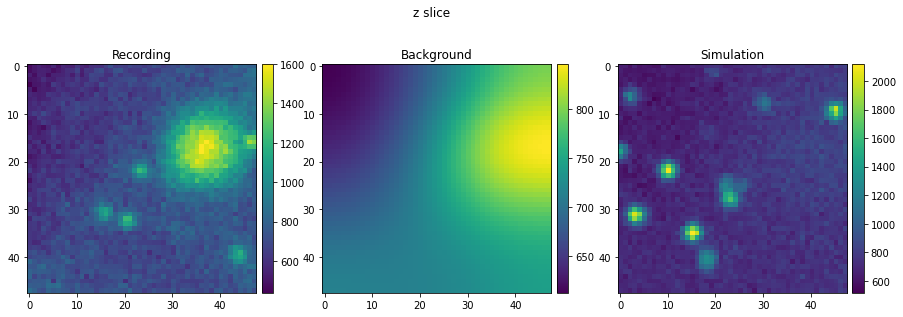

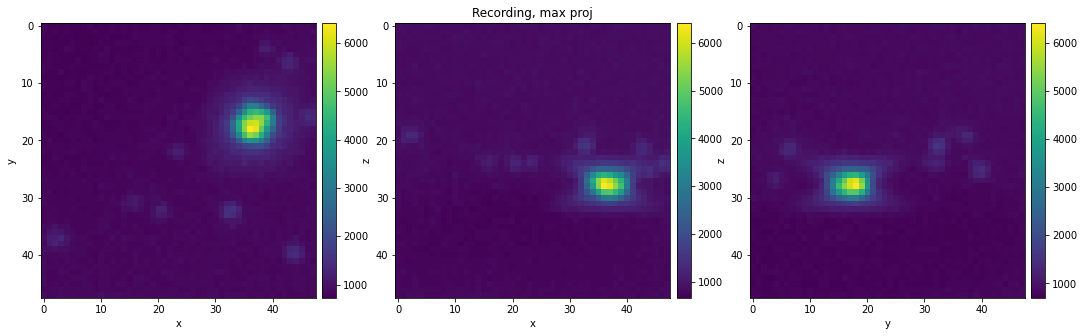

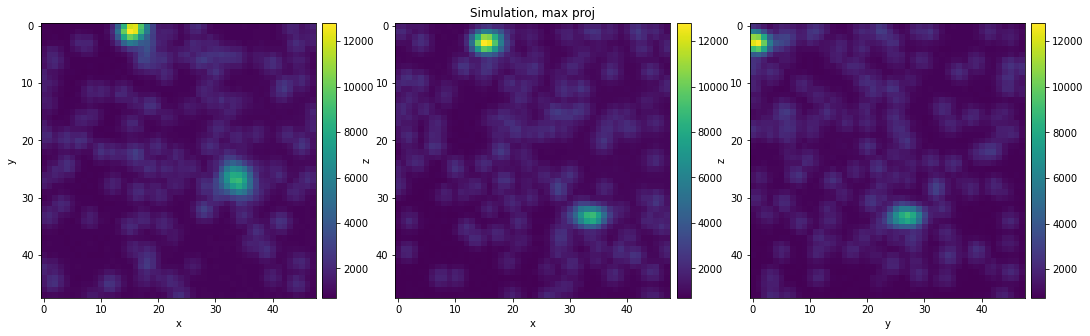

In [ ]:
from decode_fish.funcs.visualization import get_simulation_statistics
get_simulation_statistics(decode_dl, micro, int_threshold=1500)

In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d[0])
model = hydra.utils.instantiate(cfg.model, inp_scale=float(inp_scale), inp_offset=float(inp_offset))

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (noise): sCMOS()
)

In [ ]:
opt_net = hydra.utils.instantiate(cfg.supervised.opt, params=model.parameters())
scheduler_net = torch.optim.lr_scheduler.StepLR(opt_net, step_size=cfg.supervised.step_size, gamma=cfg.supervised.gamma)

psf_param = list(psf.parameters())
opt_psf = hydra.utils.instantiate(cfg.autoencoder.opt_psf, params=psf_param)
opt_mic = hydra.utils.instantiate(cfg.autoencoder.opt_micro,params=list(micro.parameters())[:2])
scheduler_psf = torch.optim.lr_scheduler.StepLR(opt_psf, step_size=cfg.autoencoder.step_size, gamma=cfg.autoencoder.gamma)

if cfg.evaluation is not None:
    eval_dict = dict(cfg.evaluation)
    eval_dict['crop_sl'] = eval(eval_dict['crop_sl'],{'__builtins__': None},{'s_': np.s_})
    eval_dict['px_size'] = list(eval_dict['px_size'])
else:
    eval_dict = None
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
img,df = load_from_eval_dict(eval_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/mRNAlevel_200/foci/strong/w1*.txt'

In [ ]:
cfg.evaluation

{'image_path': '${data_path.image_path}', 'txt_path': '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/mRNAlevel_200/foci/strong/w1*.txt', 'crop_sl': 's_[:,:,100:200,100:200]', 'img_ind': 0, 'px_size': [100, 100, 300]}

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

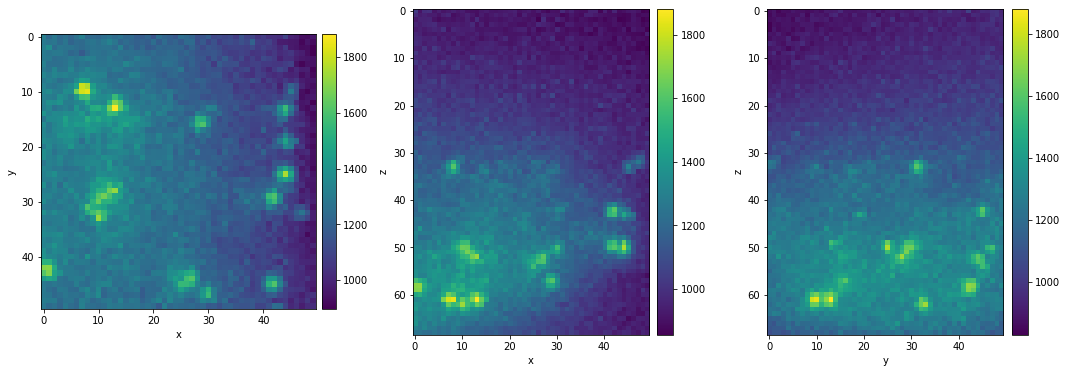

In [ ]:
plot_3d_projections(img[0],'max')

In [ ]:
if cfg.data_path.model_init is not None:
    model = load_model_state(model, cfg.data_path.model_init).cuda()
#     micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'))
    opt_net.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'opt_net.pkl'))
#     opt_psf.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'opt_psf.pkl'))
    psf.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'psf.pkl'))

FileNotFoundError: [Errno 2] No such file or directory: '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f5/min_fac:0.3/sl_save/model.pkl'

In [ ]:
# point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48]).cuda()*.0001, min_int = 0.5, sim_iters=5)
# locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

In [ ]:
# xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
# plot_3d_projections(xsim[0,0])

In [ ]:
_ = wandb.init(project=cfg.output.project, 
               config=OmegaConf.to_container(cfg, resolve=True),
               dir=cfg.output.log_dir,
               group=cfg.output.group,
               name=cfg.run_name
          )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aspeiser (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


0


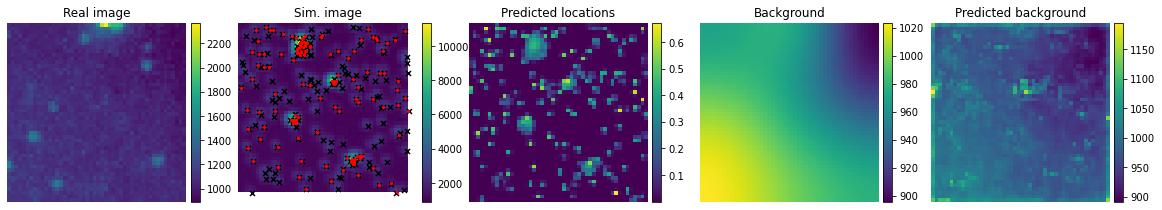

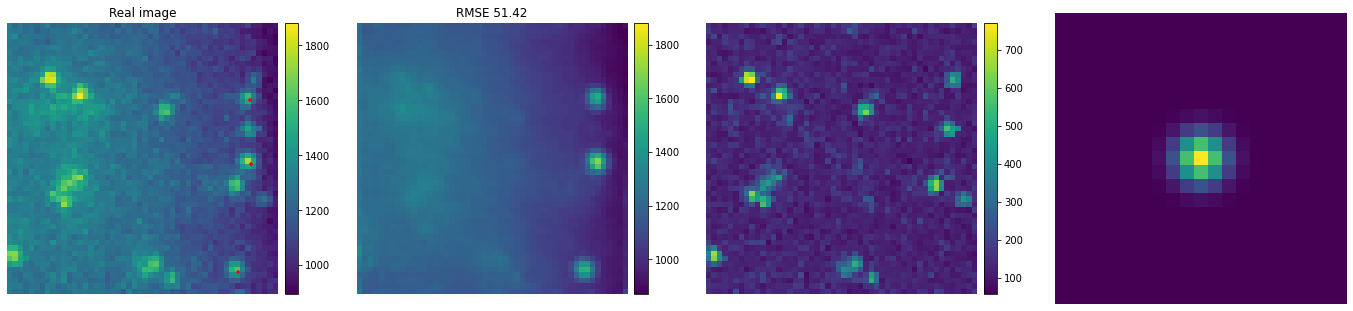

100


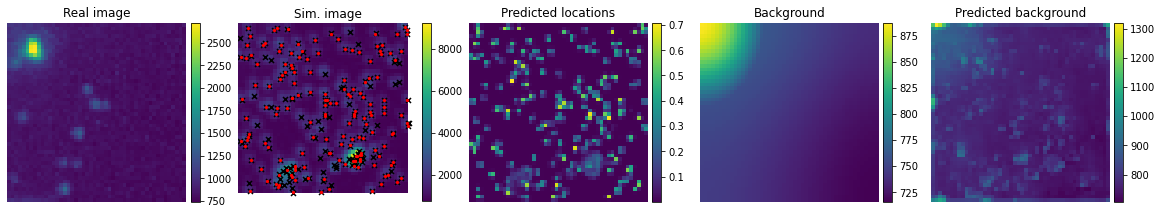

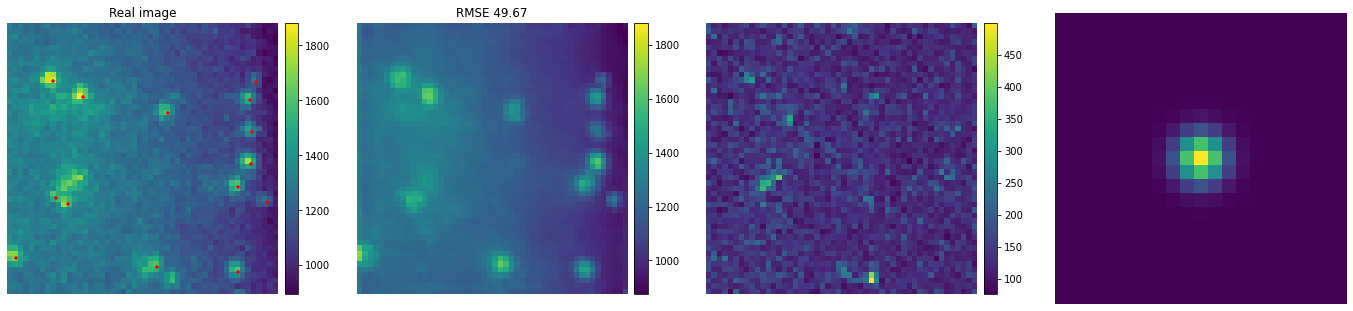

200


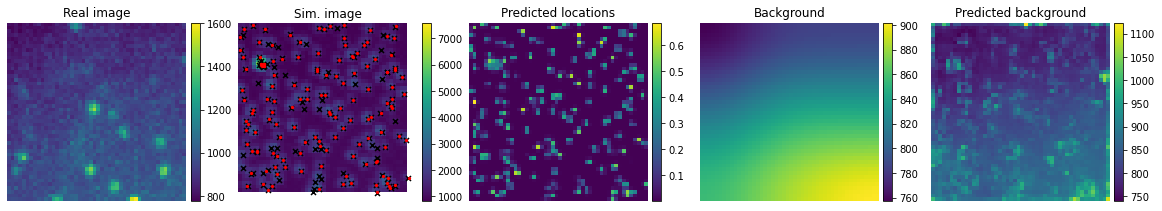

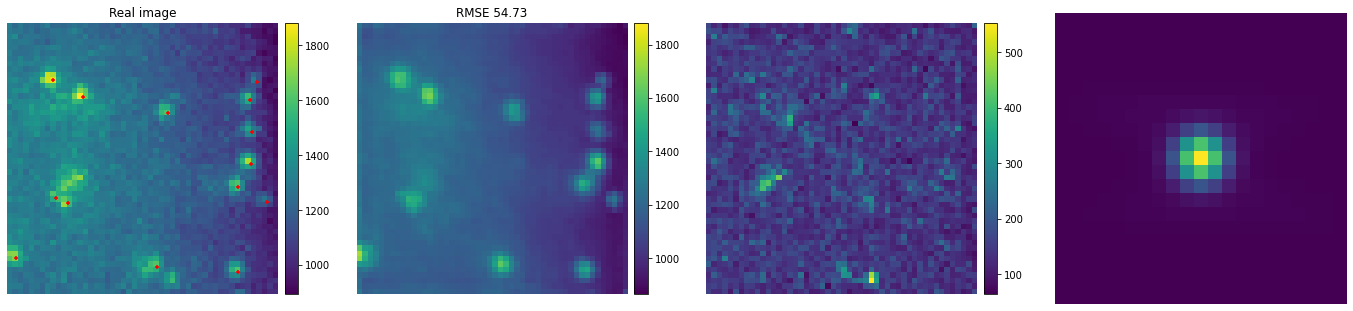

KeyboardInterrupt: 

In [ ]:
train(cfg=cfg,
     model=model, 
     dl=decode_dl, 
     optim_net=opt_net, 
     optim_psf=opt_psf, 
     optim_mic=opt_mic, 
     sched_net=scheduler_net, 
     sched_psf=scheduler_psf, 
     psf=psf,
     post_proc=post_proc,
     microscope=micro, 
     eval_dict=eval_dict)

In [ ]:
free_mem()

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted index.ipynb.
